In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd

import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize, scale
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

In [ ]:
DEBUG = False

train_ori = pd.read_csv('/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/train.csv')
test_ori = pd.read_csv('/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/test.csv')
submission = pd.read_csv('/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/sample_submission.csv')

if DEBUG:
    train = train[:80*10000]

In [ ]:
train_ori.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


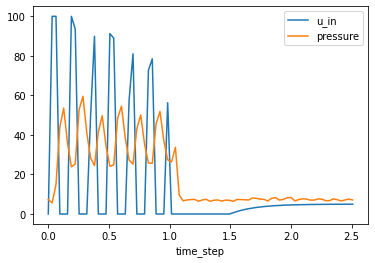

In [ ]:
a=train_ori.where(train_ori["breath_id"]==928)
a.plot(x="time_step", y=["u_in","pressure"])

In [ ]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

train = add_features(train_ori)
test = add_features(test_ori)

#MAX=train["pressure"].max()
#MIN=train["pressure"].min()
#train["pressure"] = ( train["pressure"] - MIN ) / ( MAX - MIN )

In [ ]:
train_ori.plot.scatter(x="R*C", y=["pressure"])

In [ ]:
train

,id,breath_id,time_step,u_in,u_out,pressure,breath_id__u_in__diffmax,breath_id__u_in__diffmean,area,cross,cross2,u_in_cumsum,one,count,u_in_cummean,breath_id_lag,breath_id_lag2,breath_id_lagsame,breath_id_lag2same,u_in_lag,u_in_lag2,u_out_lag2,R_20,R_5,R_50,C_10,C_20,C_50,R*C_100,R*C_1000,R*C_200,R*C_250,R*C_2500,R*C_400,R*C_50,R*C_500,RC_2010,RC_2020,RC_2050,RC_5010,RC_5020,RC_5050,RC_510,RC_520,RC_550
0,1,1,0.000000,0.083334,0,5.837492,28.229702,10.062673,0.000000,0.000000,0.000000,0.083334,1,1,0.083334,0.0,0.0,0,0,0.000000,0.000000,0.0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,1,0.033652,18.383041,0,5.907794,9.929994,-8.237035,0.618632,0.000000,0.000000,18.466375,1,2,9.233188,1.0,0.0,1,0,0.083334,0.000000,0.0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,1,0.067514,22.509278,0,7.876254,5.803758,-12.363271,2.138333,0.000000,0.000000,40.975653,1,3,13.658551,1.0,1.0,1,1,18.383041,0.083334,0.0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,1,0.101542,22.808822,0,11.742872,5.504214,-12.662816,4.454391,0.000000,0.000000,63.784476,1,4,15.946119,1.0,1.0,1,1,22.509278,18.383041,0.0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5,1,0.135756,25.355850,0,12.234987,2.957185,-15.209844,7.896588,0.000000,0.000000,89.140326,1,5,17.828065,1.0,1.0,1,1,22.808822,22.509278,0.0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,2.504603,1.489714,1,3.869032,24.014482,3.421689,270.089574,1.489714,2.504603,387.109297,1,76,5.093543,125749.0,125749.0,1,1,1.420711,1.353205,1.0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
6035996,6035997,125749,2.537961,1.488497,1,3.869032,24.015699,3.422905,273.867320,1.488497,2.537961,388.597794,1,77,5.046725,125749.0,125749.0,1,1,1.489714,1.420711,1.0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
6035997,6035998,125749,2.571408,1.558978,1,3.798729,23.945218,3.352424,277.876088,1.558978,2.571408,390.156772,1,78,5.002010,125749.0,125749.0,1,1,1.488497,1.489714,1.0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
6035998,6035999,125749,2.604744,1.272663,1,4.079938,24.231532,3.638739,281.191050,1.272663,2.604744,391.429435,1,79,4.954803,125749.0,125749.0,1,1,1.558978,1.488497,1.0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [ ]:
train.shape

(6036000, 28)

In [ ]:
test.shape

(4024000, 28)

In [ ]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['id',  'pressure', 'breath_id'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id'], axis=1)

In [ ]:
RS = RobustScaler()

train = RS.fit_transform(train)
test = RS.transform(test)

In [ ]:
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])


In [ ]:

import gc
gc.collect()

In [ ]:
train.shape

(75450, 80, 50)

In [ ]:
EPOCH = 300
BATCH_SIZE = 512
FOLD=10
visit=[0,1,2,3,4,5,6,7]

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    kf = KFold(n_splits=FOLD, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        if fold in visit:
          continue
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        model = keras.models.Sequential([
            keras.layers.Input(shape=train.shape[-2:]),
            keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
            keras.layers.Dense(100, activation='selu'),
            keras.layers.Dense(1),
        ])
        model.compile(optimizer="adam", loss="mae")

        scheduler = ExponentialDecay(1e-3, 400*((len(train)*0.8)/BATCH_SIZE), 1e-5)
        lr = LearningRateScheduler(scheduler, verbose=1)

        es = EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min", restore_best_weights=True)

        model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr,es])
        model.save(f'/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2/FOLD{FOLD}/model2_Fold{fold+1}.h5')
        test_preds.append(model.predict(test).squeeze().reshape(-1, 1).squeeze())

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.46.240.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.46.240.106:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


--------------- > Fold 1 < ---------------
--------------- > Fold 2 < ---------------
--------------- > Fold 3 < ---------------
--------------- > Fold 4 < ---------------
--------------- > Fold 5 < ---------------
--------------- > Fold 6 < ---------------
--------------- > Fold 7 < ---------------
--------------- > Fold 8 < ---------------
--------------- > Fold 9 < ---------------
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
133/133 [==============================] - 118s 628ms/step - loss: 1.7318 - val_loss: 0.8659
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009997559, shape=(), dtype=float32).
133/133 [==============================] - 53s 396ms/step - loss: 0.6651 - val_loss: 0.5604
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009995119, shape=(), dtype=float32).
133/133 [==============================] - 53s 396ms/step - loss: 

In [ ]:
submission["pressure"] = sum(test_preds)/FOLD
#submission["pressure"] = submission["pressure"] * (MAX - MIN) + MIN
submission.to_csv('/content/drive/My Drive/Kaggle/ventilator-pressure-prediction/model2_fold10.csv', index=False)

In [ ]:
submission.head()

,id,pressure
0,1,6.259634
1,2,5.916657
2,3,7.136548
3,4,7.632617
4,5,9.136795


In [ ]:
train

array([[[-0.98905216, -0.93738445, -1.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.96360815,  3.04927811, -1.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.93800551,  3.94819476, -1.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.99323196,  0.12977577,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.01891789,  0.13039356,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.04464022,  0.13091551,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.98905216,  1.69886631, -1.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.96334713,  2.09010313, -1.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.9375242 ,  1.78379121, -1.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.99376338,  0.13021357,  0.        , ...,  